In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
# import all libraries and dependencies for data visualization
pd.options.display.float_format='{:.4f}'.format
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1) 
sns.set(style='darkgrid')
import matplotlib.ticker as plticker
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

In [4]:
country_df = pd.read_csv("Country-data.csv")
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,10.0000,7.5800,44.9000,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,28.0000,6.5500,48.6000,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,38.4000,4.1700,31.4000,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,62.3000,2.8500,42.9000,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,45.5000,6.0300,58.9000,19100,1.4400,76.8000,2.1300,12200


In [5]:
country_df.shape

(167, 10)

In [6]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [7]:
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000
mean,38.2701,41.1090,6.8157,46.8902,17144.6886,7.7818,70.5557,2.9480,12964.1557
std,40.3289,27.4120,2.7468,24.2096,19278.0677,10.5707,8.8932,1.5138,18328.7048
min,2.6000,0.1090,1.8100,0.0659,609.0000,-4.2100,32.1000,1.1500,231.0000
25%,8.2500,23.8000,4.9200,30.2000,3355.0000,1.8100,65.3000,1.7950,1330.0000
50%,19.3000,35.0000,6.3200,43.3000,9960.0000,5.3900,73.1000,2.4100,4660.0000
75%,62.1000,51.3500,8.6000,58.7500,22800.0000,10.7500,76.8000,3.8800,14050.0000
max,208.0000,200.0000,17.9000,174.0000,125000.0000,104.0000,82.8000,7.4900,105000.0000


## Clean the data

In [8]:
# checking missing values
round(100*(country_df.isnull().sum())/len(country_df),2)

country      0.0000
child_mort   0.0000
exports      0.0000
health       0.0000
imports      0.0000
income       0.0000
inflation    0.0000
life_expec   0.0000
total_fer    0.0000
gdpp         0.0000
dtype: float64

**Inference:** None of the columns have null values hence no imputation or drop required.

In [9]:
# Datatype check for the dataframe

country_df.dtypes

country       object 
child_mort    float64
exports       float64
health        float64
imports       float64
income        int64  
inflation     float64
life_expec    float64
total_fer     float64
gdpp          int64  
dtype: object

**Inference:** None of the columns have inconsistent datatype, hence no conversion is required.

In [10]:
# checking for duplicates, if any

country_df.loc[country_df.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


In [11]:
# Segregation of Numerical and Categorical Variables/Columns

cat_columns = country_df.select_dtypes(include = ['object']).columns
num_columns = country_df.select_dtypes(exclude = ['object']).columns

The dataset seems to be almost clean and hence no such cleansing activities are required.

## Data Visualization

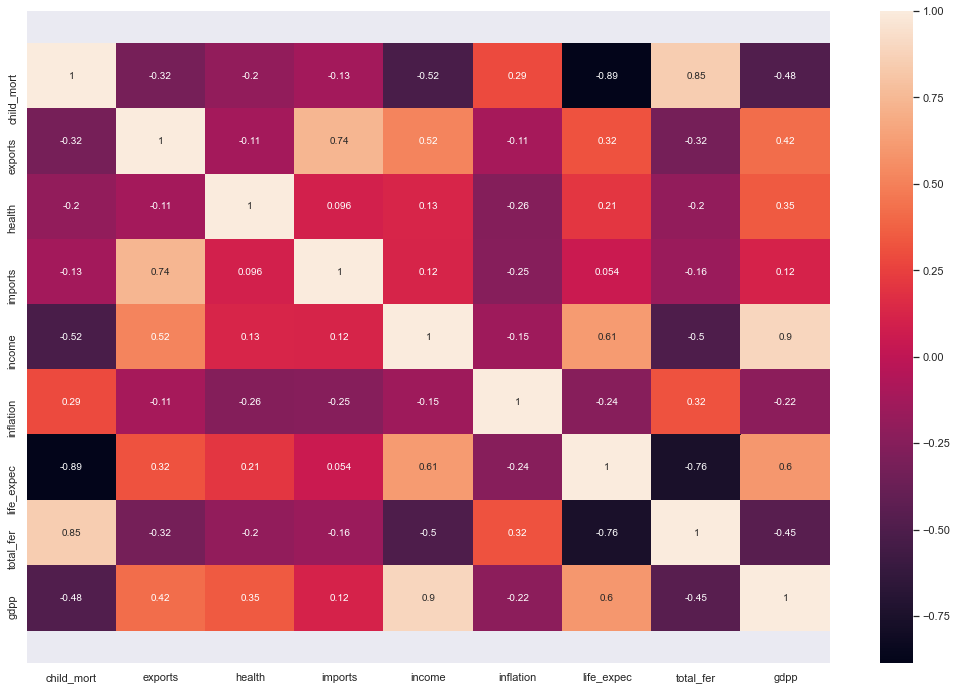

In [12]:
# Heatmap to understand the attributes dependency

plt.figure(figsize = (18,12))        
ax = sns.heatmap(country_df.corr(),annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

**Inferences:** <br>
1.child_mort and life_expec are highly correlated with correlation -0.89 <br>
2.income and gdpp are highly correlated with correlation 0.9 <br>
3.child_mort and total_fer are highly correlated with correlation 0.85 <br>
4.imports and exports are highly correlated with correlation 0.74

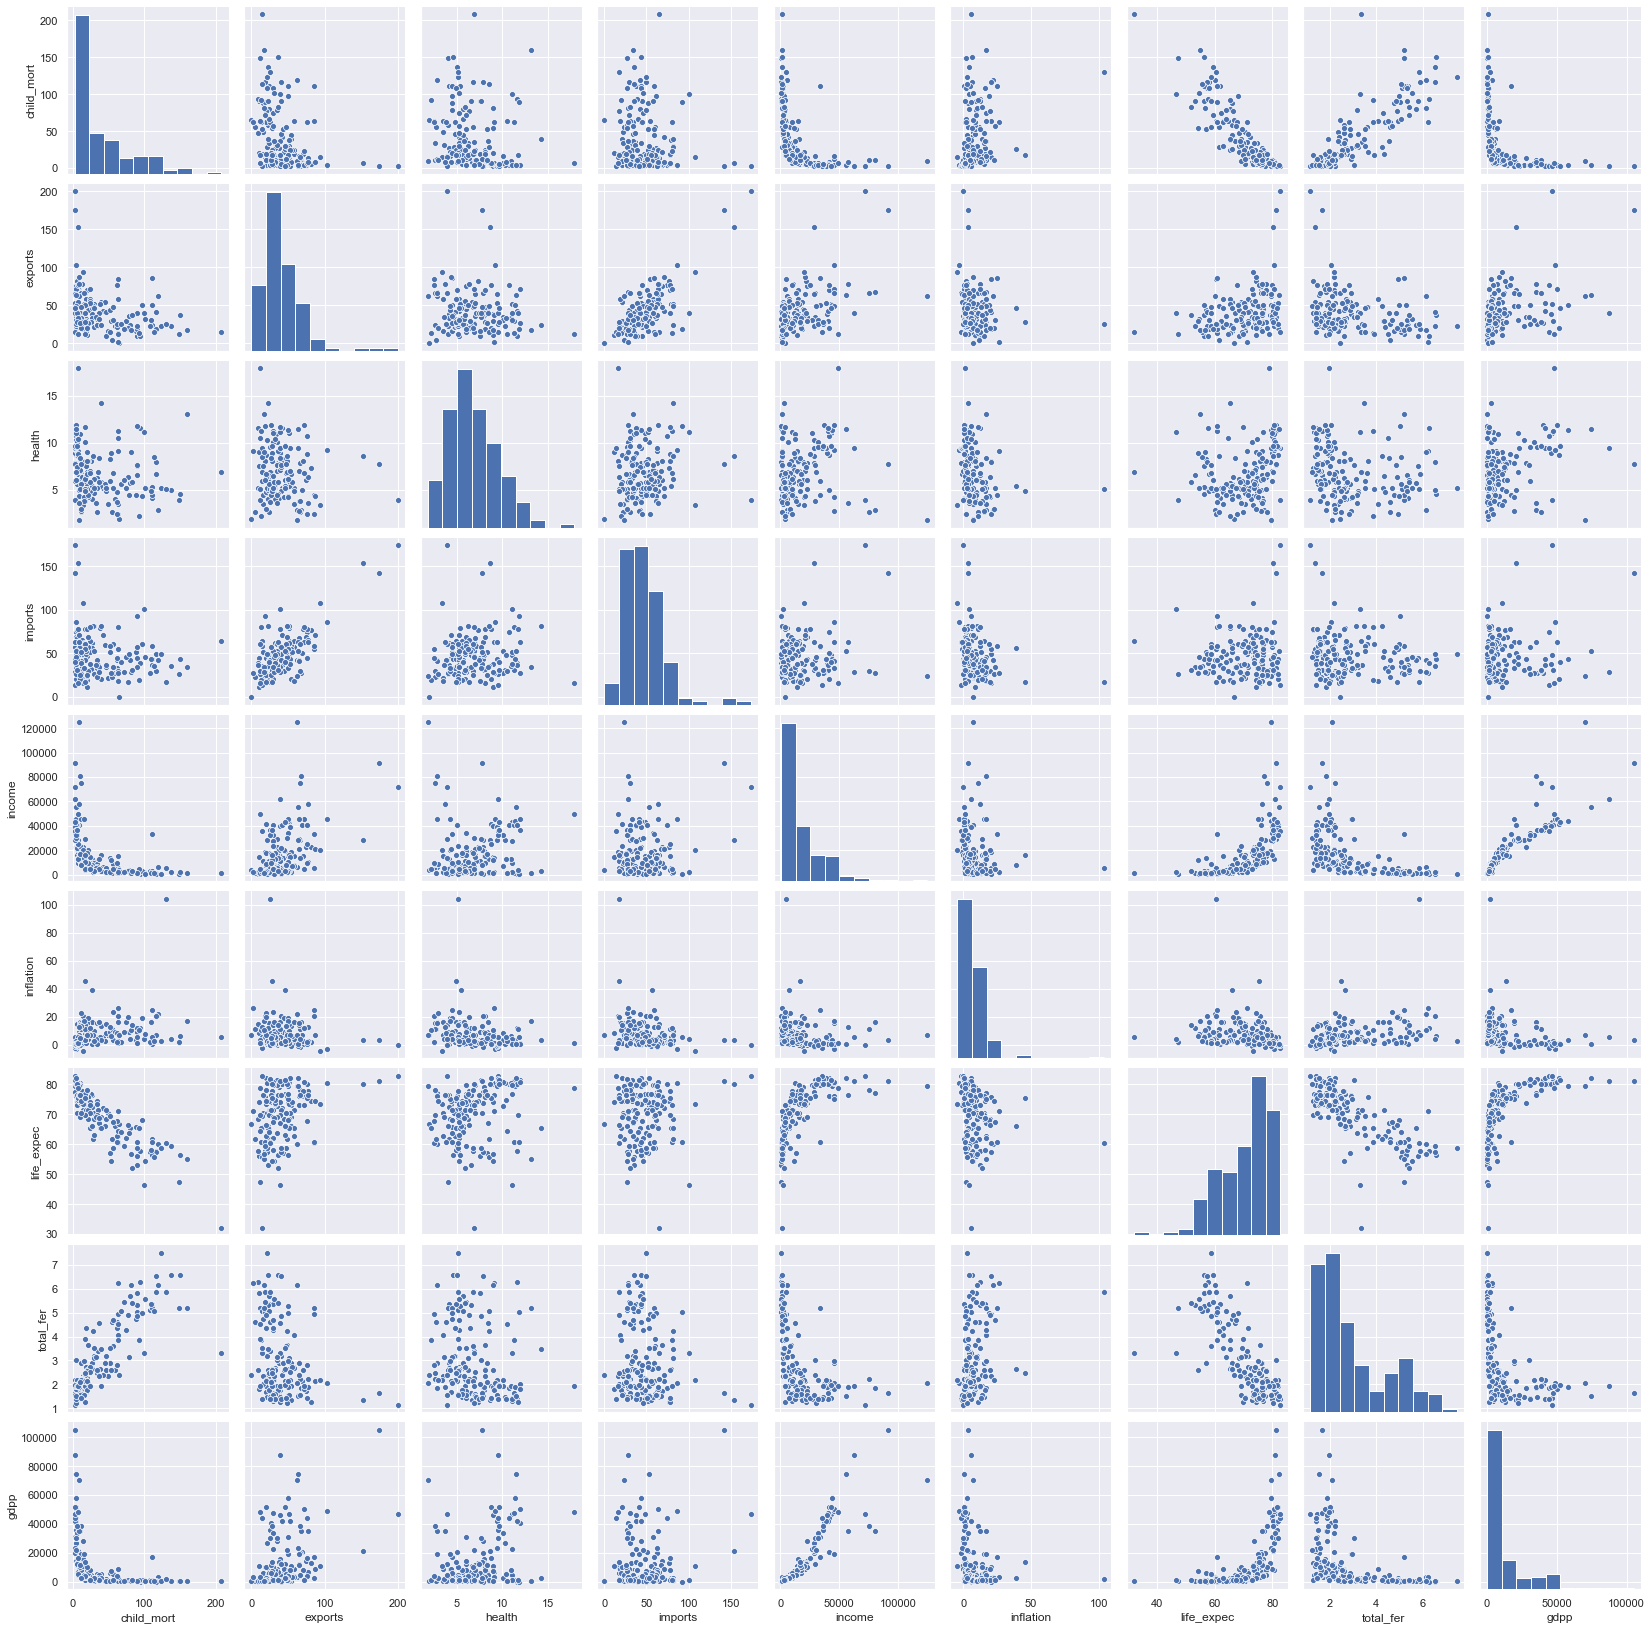

In [13]:
# Pairplot of all numeric columns

sns.pairplot(country_df)
plt.show()

## Data Preparation

Deducing imports,exports and health from percentage values to actual values of their GDP per capita .Because the percentage values don't give a much information about a particular country.

In [14]:
# Converting exports,imports and health spending percentages to absolute values.

country_df['exports'] = country_df['exports'] * country_df['gdpp']/100
country_df['imports'] = country_df['imports'] * country_df['gdpp']/100
country_df['health'] = country_df['health'] * country_df['gdpp']/100

In [15]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,1145.2000,267.8950,1987.7400,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,1712.6400,185.9820,1400.4400,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,2199.1900,100.6050,1514.3700,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,5551.0000,735.6600,7185.8000,19100,1.4400,76.8000,2.1300,12200


In [16]:
# Dropping Country column as final dataframe will only contain numerical data columns

country_df_drop = country_df.copy()
country = country_df_drop.pop('country')

In [17]:
country_df_drop.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2000,55.3000,41.9174,248.2970,1610,9.4400,56.2000,5.8200,553
1,16.6000,1145.2000,267.8950,1987.7400,9930,4.4900,76.3000,1.6500,4090
2,27.3000,1712.6400,185.9820,1400.4400,12900,16.1000,76.5000,2.8900,4460
3,119.0000,2199.1900,100.6050,1514.3700,5900,22.4000,60.1000,6.1600,3530
4,10.3000,5551.0000,735.6600,7185.8000,19100,1.4400,76.8000,2.1300,12200


## Rescaling the features

There are two common ways of rescaling:

1. Min-Max scaling
2. Standardisation 

Here, I am going to use Standardisation scaling.

In [18]:
# Standarisation technique for scaling

scaler = StandardScaler()
country_df_scaled = scaler.fit_transform(country_df_drop)

In [19]:
country_df_scaled

array([[ 1.29153238, -0.4110113 , -0.56503989, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.35019096, -0.43921769, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.31852577, -0.48482608, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541, -0.36146329, -0.53848844, ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.39216643, -0.55059641, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.38395214, -0.54049845, ..., -2.09278484,
         1.6246091 , -0.62954556]])

## PCA - Principal component analysis

I am doing PCA because I want to remove the redundancies in the data and find the most important directions where the data was aligned. A somewhat similar heuristic is also used by the United Nations to calculate the Human Development Index(HDI) to rank countries on the basis of their development. <br>
I know we didn't go to PCA module yet but still i am doing PCA since it is one of the most commonly used dimensionality reduction techniques in the industry. By converting large data sets into smaller ones containing fewer variables, it helps in improving model performance, visualising complex data sets, and in many more areas.

Let's use PCA for dimensionality reduction as from the heatmap we can see that there is a high correlation between variables.

In [20]:
pca = PCA(svd_solver='randomized', random_state=42)

In [21]:
# Lets apply PCA on the scaled data

pca.fit(country_df_scaled)

PCA(random_state=42, svd_solver='randomized')

In [22]:
# PCA components created 

pca.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

In [23]:
# Variance Ratio

pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

Text(0, 0.5, 'Variance Ratio')

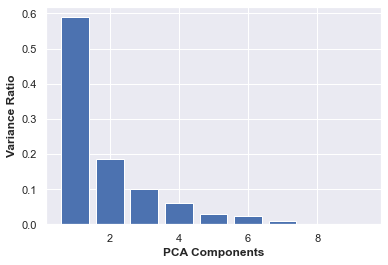

In [24]:
# Variance Ratio bar plot for each PCA components.

ax = plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel("PCA Components",fontweight = 'bold')
plt.ylabel("Variance Ratio",fontweight = 'bold')

**Inference:** From the above plot we can infer that, <br>
1. The variance explained for the first component is almost 0.6 i.e., nearly 60%
2. Similarly for second component, the variance explained is almost 20% and so on.

Text(0, 0.5, 'Cumulative Variance Explained')

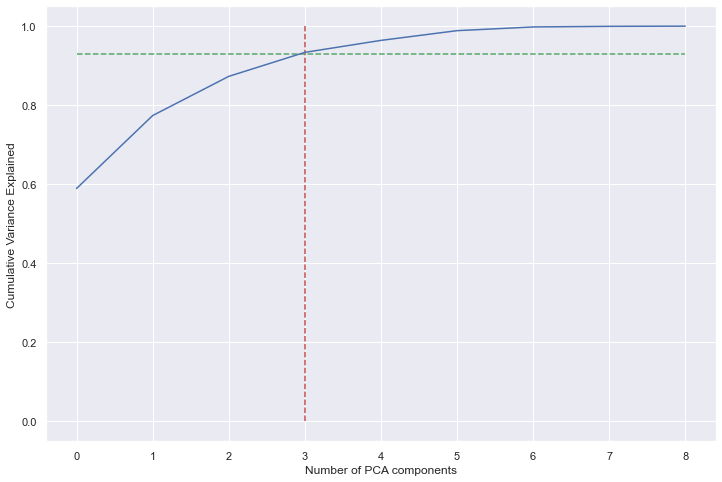

In [25]:
# Scree plot to visualize the Cumulative variance against the Number of components

fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.vlines(x=3, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.93, xmax=8, xmin=0, colors="g", linestyles="--")
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Variance Explained')

**Inference:** From the above plot we can infer that more than 90% variance is explained by the first 3 principal components. Hence, i will use these components only and go forward for Clustering process.

In [26]:
# Checking which attributes are well explained by the pca components

original_col = list(country_df.drop(['country'],axis=1).columns)
attributes_pca = pd.DataFrame({'Attribute':original_col,'PC_1':pca.components_[0],'PC_2':pca.components_[1],'PC_3':pca.components_[2]})

In [27]:
attributes_pca

,Attribute,PC_1,PC_2,PC_3
0,child_mort,-0.3164,0.4763,-0.1500
1,exports,0.3429,0.3973,-0.0306
2,health,0.3585,0.1551,-0.0757
3,imports,0.3449,0.3708,-0.0722
4,income,0.3800,0.1284,0.1458
5,inflation,-0.1431,0.2213,0.9484
6,life_expec,0.3439,-0.3698,0.1968
7,total_fer,-0.3028,0.4597,-0.0778
8,gdpp,0.4000,0.2006,0.0103


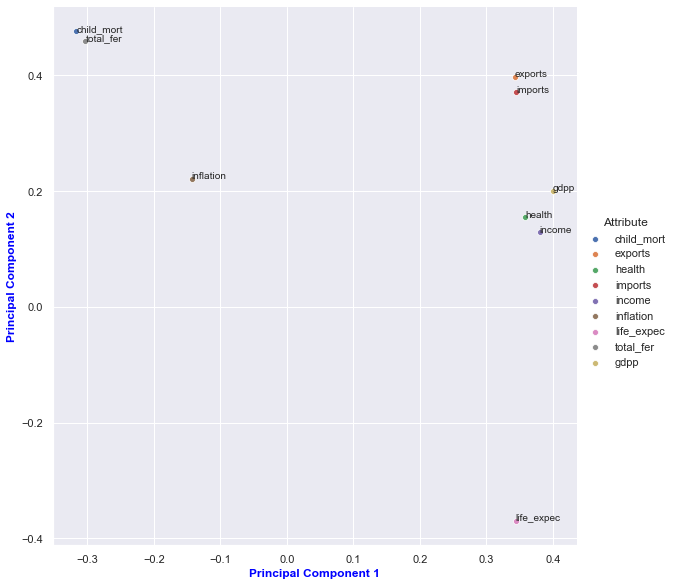

In [28]:
# Plotting the above dataframe for better visualization with PC1 and PC2

sns.pairplot(data=attributes_pca, x_vars=["PC_1"], y_vars=["PC_2"], hue = "Attribute" ,height=8)
plt.xlabel("Principal Component 1",fontweight = 'bold', color = 'blue')
plt.ylabel("Principal Component 2",fontweight = 'bold', color = 'blue')

for i,txt in enumerate(attributes_pca.Attribute):
    plt.annotate(txt, (attributes_pca.PC_1[i],attributes_pca.PC_2[i]))

**Inferences:**
1. life expectency, income, gdpp and health are very well explained by PC1 but not much by PC2
2. imports and exports are well explained by both the components PC1 and PC2.
3. child mortality and total fertility are well explained by PC2 but not much by PC1
4. inflation is neither explained well by PC1 nor with PC2

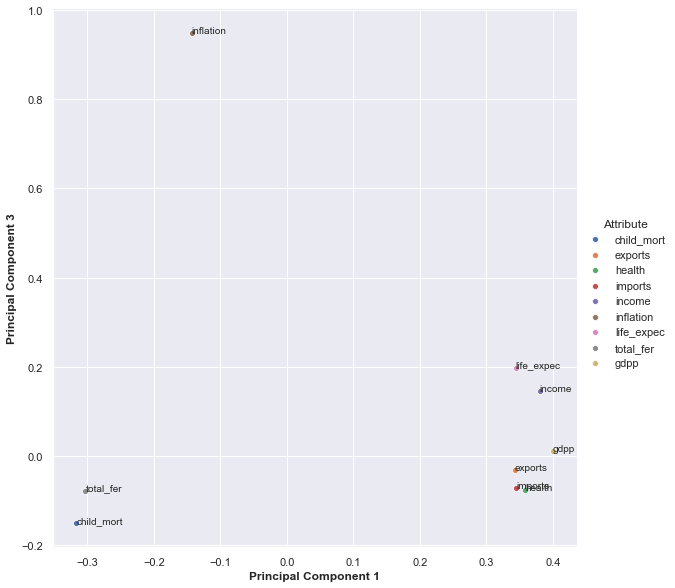

In [29]:
# Plotting the above dataframe with PC1 and PC3 to understand the components which explains inflation.

sns.pairplot(data=attributes_pca, x_vars=["PC_1"], y_vars=["PC_3"], hue = "Attribute" ,height=8)
plt.xlabel("Principal Component 1",fontweight = 'bold')
plt.ylabel("Principal Component 3",fontweight = 'bold')

for i,txt in enumerate(attributes_pca.Attribute):
    plt.annotate(txt, (attributes_pca.PC_1[i],attributes_pca.PC_3[i]))

**Inferences:**
 From the above plot we can infer that, 
 1. life expectancy, gdpp, income, imports, exports and health are very well explained by PC1 
 2. Inflation is explained well by PC3

Since 90% variance is explained by 3 principal components, let us build the dataframe using those 3 components only.

In [30]:
# Building the dataframe using Incremental PCA for better efficiency.

incr_pca = IncrementalPCA(n_components=3)

In [31]:
# Fitting the scaled df on incremental pca

incr_pca_df= incr_pca.fit_transform(country_df_scaled)
incr_pca_df

array([[-2.63744157e+00,  1.46903797e+00, -5.41359106e-01],
       [-2.22769569e-02, -1.43189586e+00, -2.07009539e-02],
       [-4.57626261e-01, -6.73300938e-01,  9.61867281e-01],
       [-2.72452030e+00,  2.17458267e+00,  6.06686548e-01],
       [ 6.49848516e-01, -1.02437392e+00, -2.50102847e-01],
       [ 3.71968554e-02, -6.80889086e-01,  1.46696276e+00],
       [-3.32691520e-01, -1.27451685e+00,  1.76636110e-01],
       [ 3.18036154e+00, -2.50784878e-01, -1.16877257e-01],
       [ 3.81568156e+00,  2.56083499e-01, -2.70495294e-01],
       [-4.67515152e-01, -4.93492360e-01,  6.03288028e-01],
       [ 1.49875246e+00, -4.28907400e-01, -5.50237572e-01],
       [ 1.47097104e+00, -3.26795693e-01,  4.28411771e-01],
       [-1.01419903e+00, -7.11807758e-01, -1.16988551e-01],
       [ 8.45238116e-01, -1.00860625e+00, -4.17261615e-01],
       [-1.34473920e-02, -9.82186148e-01,  8.80913018e-01],
       [ 3.96087770e+00,  8.38740841e-01, -2.94077196e-01],
       [-4.02707071e-01, -9.21816189e-01

In [32]:
# Creating new dataframe with Principal components

pca_df = pd.DataFrame(incr_pca_df, columns=["PC_1", "PC_2","PC_3"])
pca_df_final = pd.concat([country, pca_df], axis=1)
pca_df_final.head()

,country,PC_1,PC_2,PC_3
0,Afghanistan,-2.6374,1.4690,-0.5414
1,Albania,-0.0223,-1.4319,-0.0207
2,Algeria,-0.4576,-0.6733,0.9619
3,Angola,-2.7245,2.1746,0.6067
4,Antigua and Barbuda,0.6498,-1.0244,-0.2501


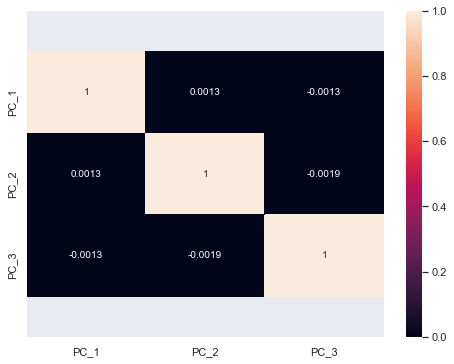

In [33]:
# Plotting Heatmap to check is there still dependency in the dataset.

plt.figure(figsize = (8,6))        
ax = sns.heatmap(pca_df_final.corr(),annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

**Inference:** From the above heatmap we can infer that, there is almost zero correlation between the attributes, so we can proceed with this dataframe.

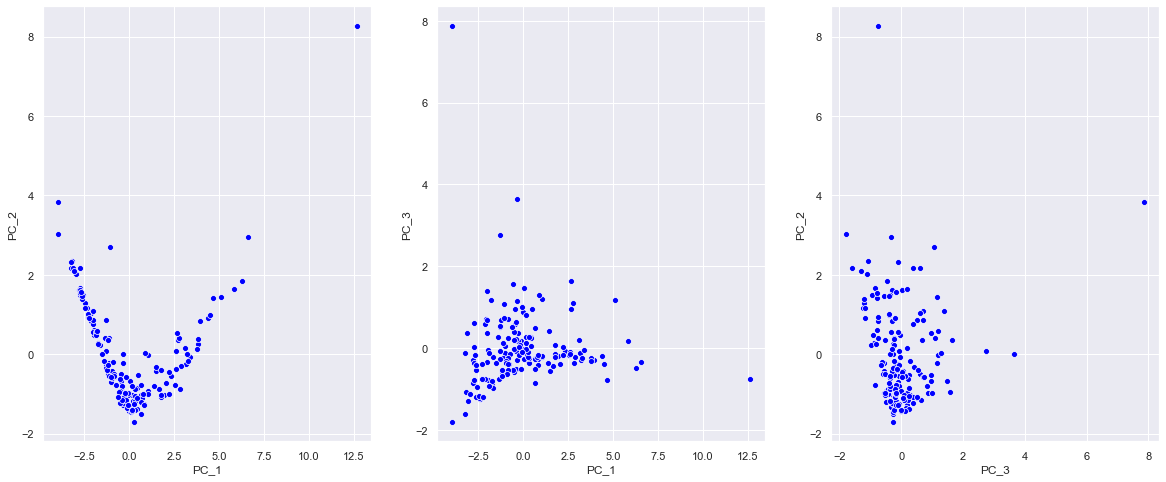

In [34]:
# Scatter Plot to visualize the spread of data across PCA components

plt.figure(figsize=(20, 8))
plt.subplot(1,3,1)
sns.scatterplot(data=pca_df_final, x='PC_1', y='PC_2', color = 'blue')
plt.subplot(1,3,2)
sns.scatterplot(data=pca_df_final, x='PC_1', y='PC_3', color = 'blue')
plt.subplot(1,3,3)
sns.scatterplot(data=pca_df_final, x='PC_3', y='PC_2', color = 'blue')

## Outlier Analysis and Treatment
There are 2 types of outliers and we will treat outliers as it can skew our dataset

1. Statistical
2. Domain specific

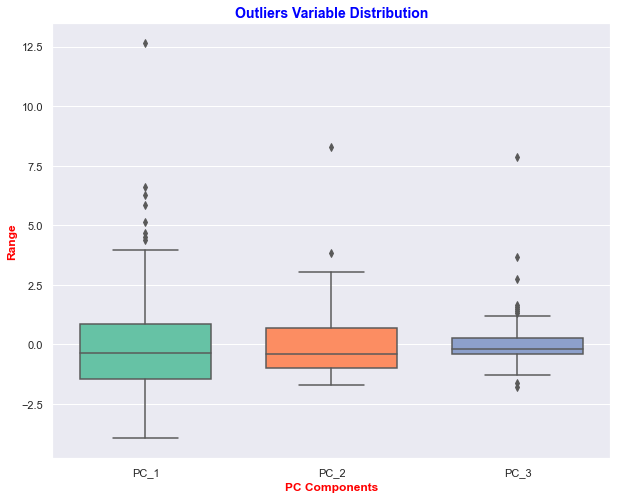

In [35]:
# Outlier Analysis 

outliers = ['PC_1','PC_2','PC_3']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = pca_df_final[outliers], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold', color = 'blue')
plt.ylabel("Range", fontweight = 'bold', color = 'red')
plt.xlabel("PC Components", fontweight = 'bold', color = 'red')
plt.show()

In [36]:
# Statstical Outlier treatment for PC_1

Q1 = pca_df_final.PC_1.quantile(0.05)
Q3 = pca_df_final.PC_1.quantile(0.95)
IQR = Q3 - Q1
pca_df_final = pca_df_final[(pca_df_final.PC_1 >= Q1) & (pca_df_final.PC_1 <= Q3)]

# Statstical Outlier treatment for PC_2

Q1 = pca_df_final.PC_2.quantile(0.05)
Q3 = pca_df_final.PC_2.quantile(0.95)
IQR = Q3 - Q1
pca_df_final = pca_df_final[(pca_df_final.PC_2 >= Q1) & (pca_df_final.PC_2 <= Q3)]

# Statstical Outlier treatment for PC_3

Q1 = pca_df_final.PC_3.quantile(0.05)
Q3 = pca_df_final.PC_3.quantile(0.95)
IQR = Q3 - Q1
pca_df_final = pca_df_final[(pca_df_final.PC_3 >= Q1) & (pca_df_final.PC_3 <= Q3)]

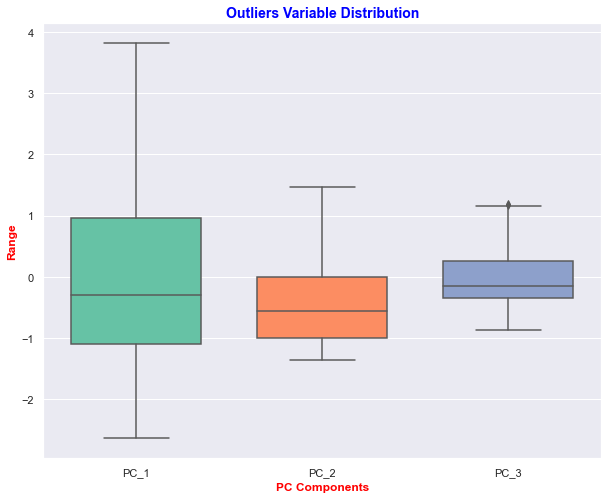

In [37]:
# Plot after Outlier removal 

outliers = ['PC_1','PC_2','PC_3']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = pca_df_final[outliers], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold', color = 'blue')
plt.ylabel("Range", fontweight = 'bold', color = 'red')
plt.xlabel("PC Components", fontweight = 'bold', color = 'red')
plt.show()

In [38]:
# Reindexing the df after outlier removal

pca_df_final = pca_df_final.reset_index(drop=True)
pca_df_final_data = pca_df_final.drop(['country'],axis=1)
pca_df_final.head()

,country,PC_1,PC_2,PC_3
0,Afghanistan,-2.6374,1.4690,-0.5414
1,Algeria,-0.4576,-0.6733,0.9619
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501
3,Armenia,-0.3327,-1.2745,0.1766
4,Australia,3.1804,-0.2508,-0.1169


## Hopkins Statistics Test

The Hopkins statistic is a method of measuring the cluster tendency of a data set.It acts as a statistical hypothesis test where the null hypothesis is the data generated by a Poisson point process and are thus uniformly randomly distributed. A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.

In [39]:
# Calculating Hopkins score to know whether the data is good for clustering or not.

def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [40]:
# Hopkins score

hopkins(pca_df_final_data)

0.793155228176479

Since the value is between 0.7 and 0.99, there is a high chance of clustering to be formed.

## Model Building

### K- means Clustering

**Finding the Optimal Number of Clusters**

Elbow Curve to get the right number of Clusters <br>
The Elbow Method is one of the most popular methods to determine this optimal value of k.

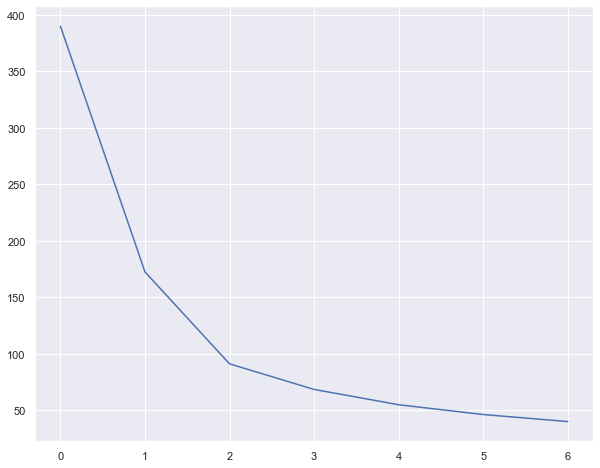

In [41]:
# Elbow curve method to find the ideal number of clusters.
ssd = []
for num_clusters in list(range(1,8)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50,random_state= 100)
    model_clus.fit(pca_df_final_data)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

**Inference:** From the above elbow curve, we can see that it looks good to proceed with either 4 or 5 clusters 

## Silhouette Analysis

In [42]:
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(pca_df)
    sse_.append([k, silhouette_score(pca_df, kmeans.labels_)])

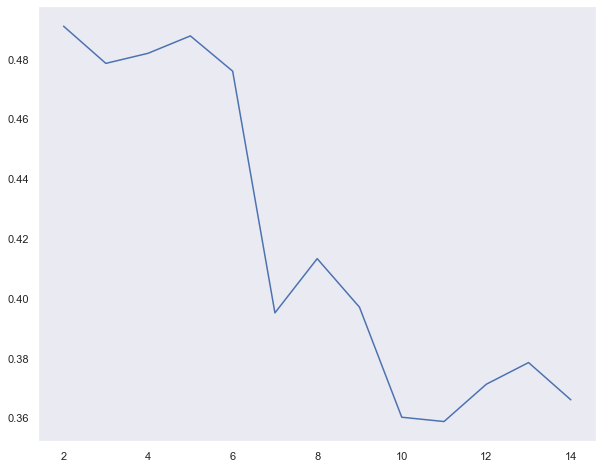

In [43]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.grid()
plt.show()

In [44]:
# Silhouette score analysis to find the ideal number of clusters for K-means clustering

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state= 100)
    kmeans.fit(pca_df_final_data)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(pca_df_final_data, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4873400103541441
For n_clusters=3, the silhouette score is 0.4639771456218248
For n_clusters=4, the silhouette score is 0.3987356568367148
For n_clusters=5, the silhouette score is 0.36085353704438133
For n_clusters=6, the silhouette score is 0.3714796089348357
For n_clusters=7, the silhouette score is 0.3609446319381151
For n_clusters=8, the silhouette score is 0.34963655749979905


In [45]:
#K-means with k=4 clusters

cluster4 = KMeans(n_clusters=4, max_iter=50, random_state= 100)
cluster4.fit(pca_df_final_data)

KMeans(max_iter=50, n_clusters=4, random_state=100)

In [46]:
# Cluster labels

cluster4.labels_

array([3, 1, 0, 1, 2, 2, 1, 0, 0, 1, 0, 1, 1, 1, 1, 3, 0, 0, 1, 2, 1, 0,
       1, 1, 3, 3, 0, 2, 0, 1, 1, 1, 1, 3, 0, 1, 2, 2, 3, 3, 1, 2, 3, 0,
       1, 1, 1, 0, 2, 1, 1, 1, 3, 0, 2, 1, 2, 1, 1, 3, 2, 1, 3, 0, 3, 0,
       0, 3, 0, 0, 2, 3, 0, 1, 1, 1, 1, 3, 1, 2, 0, 3, 0, 1, 1, 1, 0, 0,
       0, 1, 3, 1, 0, 0, 2, 3, 3, 0, 2, 1, 3, 1, 2, 1, 3, 1, 1, 0, 1, 3,
       1, 2, 2, 2, 0, 1, 1, 1, 3])

In [47]:
# Assign the label

pca_df_final['Cluster_Id4'] = cluster4.labels_
pca_df_final.head()

,country,PC_1,PC_2,PC_3,Cluster_Id4
0,Afghanistan,-2.6374,1.4690,-0.5414,3
1,Algeria,-0.4576,-0.6733,0.9619,1
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501,0
3,Armenia,-0.3327,-1.2745,0.1766,1
4,Australia,3.1804,-0.2508,-0.1169,2


In [48]:
# Number of countries in each cluster

pca_df_final['Cluster_Id4'].value_counts()

1    48
0    29
3    23
2    19
Name: Cluster_Id4, dtype: int64

**Inference:** It seems that there are good number of countries in each clusters.

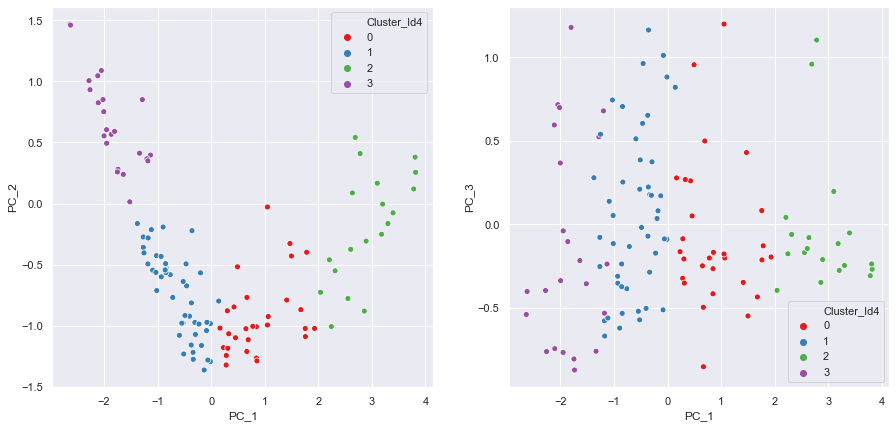

In [49]:
# Scatter plot on Principal components to visualize the spread of the data

fig, axes = plt.subplots(1,2, figsize=(15,7))

sns.scatterplot(x='PC_1',y='PC_2',hue='Cluster_Id4',legend='full',palette="Set1",data=pca_df_final,ax=axes[0])
sns.scatterplot(x='PC_1',y='PC_3',hue='Cluster_Id4',legend='full',palette="Set1",data=pca_df_final,ax=axes[1])
plt.show()

**Inference:** Frome the plot above, it seems a lot of intra-distance between the cluster elements, which is not a good sign. So, Lets drop the Cluster Id created with 4 clusters and proceed with 5 clusters.

In [50]:
pca_df_final = pca_df_final.drop('Cluster_Id4',axis=1)

In [51]:
#K-means with k=5 clusters

cluster5 = KMeans(n_clusters=5, max_iter=50,random_state=100)
cluster5.fit(pca_df_final_data)

KMeans(max_iter=50, n_clusters=5, random_state=100)

In [52]:
# Cluster labels

cluster5.labels_

array([1, 0, 3, 0, 2, 2, 0, 3, 3, 4, 3, 0, 4, 4, 4, 1, 0, 0, 4, 2, 4, 0,
       0, 0, 1, 1, 3, 2, 3, 0, 0, 4, 0, 1, 3, 4, 2, 2, 1, 1, 0, 2, 1, 3,
       0, 4, 4, 3, 2, 4, 4, 0, 1, 3, 2, 0, 2, 4, 0, 1, 2, 4, 1, 3, 1, 0,
       3, 1, 0, 0, 2, 1, 0, 4, 0, 4, 4, 1, 4, 2, 0, 1, 0, 0, 0, 4, 3, 3,
       0, 0, 1, 4, 3, 3, 3, 1, 1, 3, 3, 0, 1, 0, 2, 4, 1, 4, 0, 0, 4, 1,
       0, 2, 2, 2, 0, 4, 4, 0, 1])

In [53]:
# assign the label

pca_df_final['Cluster_Id'] = cluster5.labels_
pca_df_final.head()

,country,PC_1,PC_2,PC_3,Cluster_Id
0,Afghanistan,-2.6374,1.4690,-0.5414,1
1,Algeria,-0.4576,-0.6733,0.9619,0
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501,3
3,Armenia,-0.3327,-1.2745,0.1766,0
4,Australia,3.1804,-0.2508,-0.1169,2


In [54]:
# Number of countries in each cluster

pca_df_final['Cluster_Id'].value_counts()

0    35
4    25
1    23
3    19
2    17
Name: Cluster_Id, dtype: int64

**Inference:** Here too it seems there are good number of countries in each clusters.

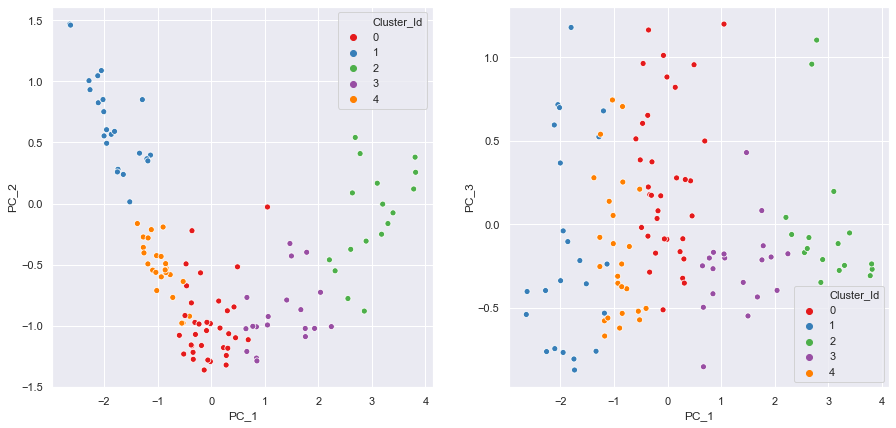

In [55]:
# Scatter plot on Principal components to visualize the spread of the data
fig, axes = plt.subplots(1,2, figsize=(15,7))

sns.scatterplot(x='PC_1',y='PC_2',hue='Cluster_Id',legend='full',palette="Set1",data=pca_df_final,ax=axes[0])
sns.scatterplot(x='PC_1',y='PC_3',hue='Cluster_Id',legend='full',palette="Set1",data=pca_df_final,ax=axes[1])

**Inference:** From this plot too we got the same issue as with 4 clusters but here we got a new segment, so lets proceed with K means using 5 clusters.

Since we have visualized the data on the principal components and saw some good clusters were formed but some were not so good hence let's now visualize the data on the original attributes.

In [56]:
# Merging the df with PCA with original df

df_merge = pd.merge(country_df,pca_df_final,on='country')
df_merge_col = df_merge[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','Cluster_Id']]

# Creating df with mean values
cluster_child = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).child_mort.mean())
cluster_export = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).exports.mean())
cluster_import = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).imports.mean())
cluster_health = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).health.mean())
cluster_income = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).income.mean())
cluster_inflation = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).inflation.mean())         
cluster_lifeexpec = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).life_expec.mean())
cluster_totalfer = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).total_fer.mean())
cluster_gdpp = pd.DataFrame(df_merge_col.groupby(["Cluster_Id"]).gdpp.mean())

df_concat = pd.concat([pd.Series([0,1,2,3,4]),cluster_child,cluster_export,cluster_import,cluster_health,cluster_income
                       ,cluster_inflation,cluster_lifeexpec,cluster_totalfer,cluster_gdpp], axis=1)
df_concat.columns = ["Cluster_Id", "Child_Mortality", "Exports", "Imports","Health_Spending","Income","Inflation","Life_Expectancy","Total_Fertility","GDPpcapita"]
df_concat.head()

,Cluster_Id,Child_Mortality,Exports,Imports,Health_Spending,Income,Inflation,Life_Expectancy,Total_Fertility,GDPpcapita
0,0,17.9000,2934.3289,2790.2077,417.9462,14125.7143,8.2583,74.0543,2.0854,6943.4286
1,1,68.4783,884.7745,838.6342,135.8739,4650.8696,10.7113,62.1696,4.5074,2152.7391
2,2,5.1412,16736.1118,15324.9353,3954.5006,41705.8824,2.8236,80.4765,1.7765,40911.7647
3,3,6.9000,9200.4895,9445.8053,1489.7879,25036.8421,0.9048,76.9579,1.6789,18810.5263
4,4,37.2160,931.7887,1241.5800,130.3515,5442.8000,6.6020,69.2320,2.9820,2416.8800


In [57]:
df_merge_col.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2000,55.3000,248.2970,41.9174,1610,9.4400,56.2000,5.8200,553,1
1,Algeria,27.3000,1712.6400,1400.4400,185.9820,12900,16.1000,76.5000,2.8900,4460,0
2,Antigua and Barbuda,10.3000,5551.0000,7185.8000,735.6600,19100,1.4400,76.8000,2.1300,12200,3
3,Armenia,18.1000,669.7600,1458.6600,141.6800,6700,7.7700,73.3000,1.6900,3220,0
4,Australia,4.8000,10276.2000,10847.1000,4530.8700,41400,1.1600,82.0000,1.9300,51900,2


Since we have been told to analyse the clusters by comparing how these three variables - (gdpp, child_mort and income) vary for each cluster of countries to recognise and differentiate the clusters of developed countries from the clusters of under-developed countries.We have also cross checked with Principal components and found that these variables have good score in PCA. Hence, we will proceed with analyzing these 3 components to build some meaningful clusters.

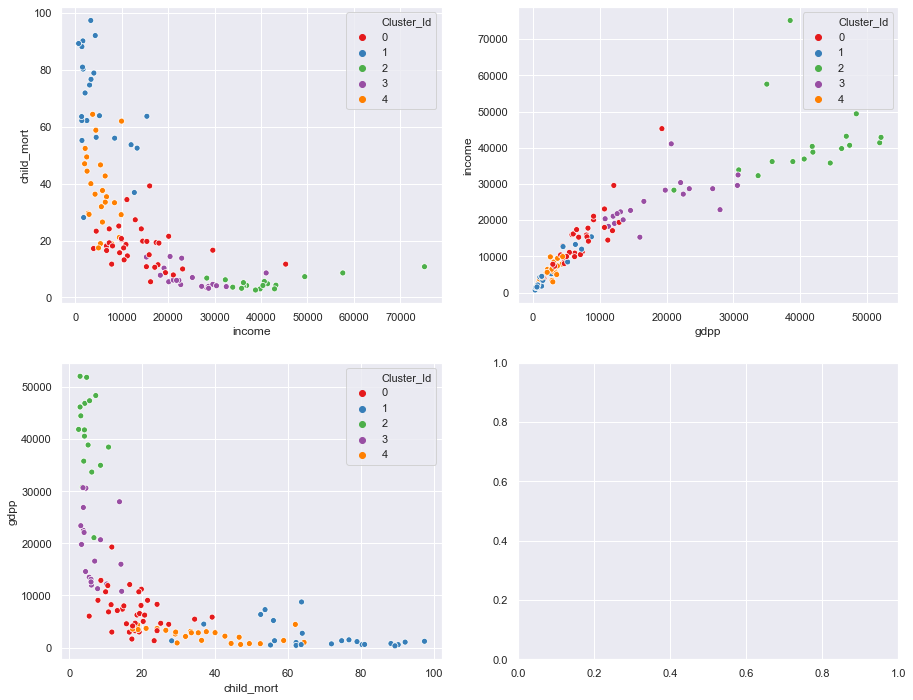

In [58]:
# Scatter plot on Original attributes to visualize the spread of the data

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.scatterplot(x = 'income', y = 'child_mort',hue='Cluster_Id',data = df_merge_col,legend='full',palette="Set1",ax=axes[0][0])
sns.scatterplot(x = 'gdpp', y = 'income',hue='Cluster_Id', data = df_merge_col,legend='full',palette="Set1",ax=axes[0][1])
sns.scatterplot(x = 'child_mort', y = 'gdpp',hue='Cluster_Id', data=df_merge_col,legend='full',palette="Set1",ax=axes[1][0])

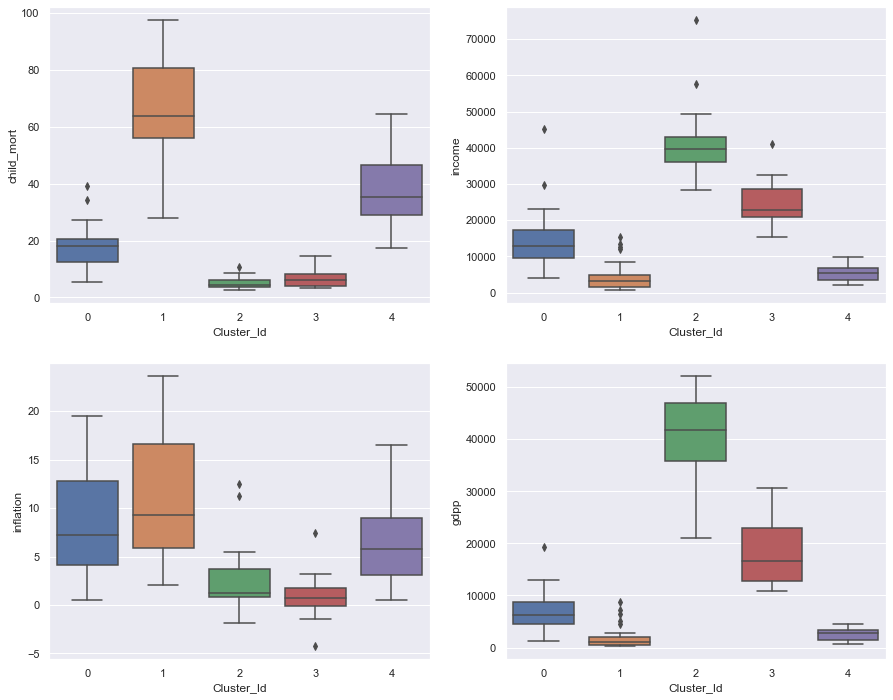

In [59]:
# Box plot on Original attributes to visualize the spread of the data

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.boxplot(x = 'Cluster_Id', y = 'child_mort', data = df_merge_col,ax=axes[0][0])
sns.boxplot(x = 'Cluster_Id', y = 'income', data = df_merge_col,ax=axes[0][1])
sns.boxplot(x = 'Cluster_Id', y = 'inflation', data=df_merge_col,ax=axes[1][0])
sns.boxplot(x = 'Cluster_Id', y = 'gdpp', data=df_merge_col,ax=axes[1][1])

**Inferences:**
1. Child Mortality is highest for Cluster 1 and Cluster 4.These clusters need some aid.
2. Income and Gdpp are measures of development. Higher the per capita income and gdpp, better is the country's development
3. Income per capita and gdpp seems lowest for countries in clusters 1 and 4. Hence, these countries need some help.

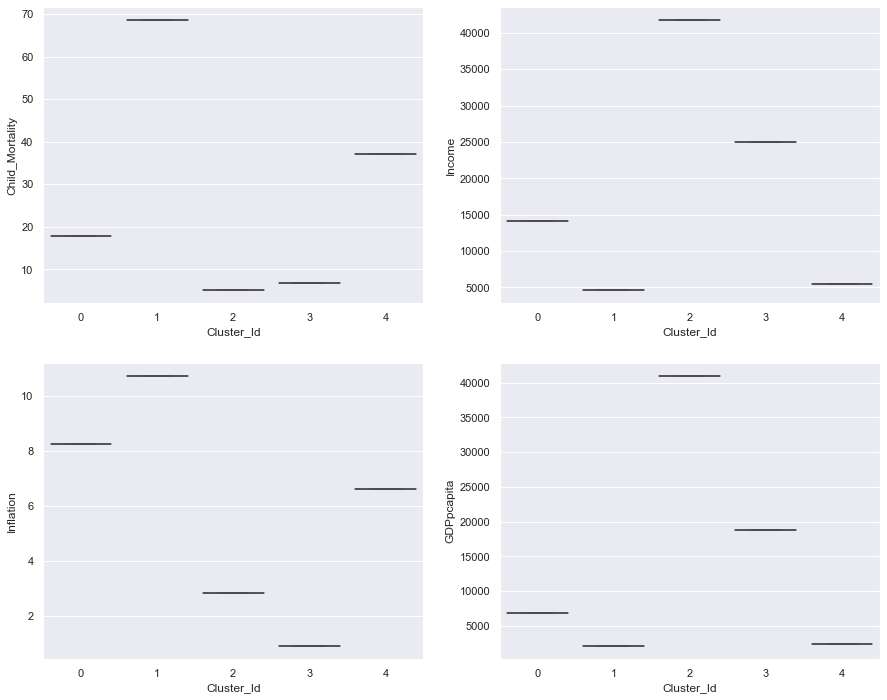

In [60]:
# Box plot to visualise the mean value of few original attributes.

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.boxplot(x = 'Cluster_Id', y = 'Child_Mortality', data = df_concat,ax=axes[0][0])
sns.boxplot(x = 'Cluster_Id', y = 'Income', data = df_concat,ax=axes[0][1])
sns.boxplot(x = 'Cluster_Id', y = 'Inflation', data=df_concat,ax=axes[1][0])
sns.boxplot(x = 'Cluster_Id', y = 'GDPpcapita', data=df_concat,ax=axes[1][1])

**Inference:** The mean values suggests similar story as above

In [61]:
# List of countries in Cluster 1

df_merge_col[df_merge_col['Cluster_Id']==1]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2000,55.3000,248.2970,41.9174,1610,9.4400,56.2000,5.8200,553,1
15,Botswana,52.5000,2768.6000,3257.5500,527.0500,13300,8.9200,57.1000,2.8800,6350,1
24,Comoros,88.2000,126.8850,397.5730,34.6819,1410,3.8700,65.9000,4.7500,769,1
25,"Congo, Rep.",63.9000,2331.7400,1498.7800,67.4040,5190,20.7000,60.4000,4.9500,2740,1
33,Eritrea,55.2000,23.0878,112.3060,12.8212,1420,11.6000,61.7000,4.6100,482,1
38,Gabon,63.7000,5048.7500,1653.7500,306.2500,15400,16.6000,62.9000,4.0800,8750,1
39,Gambia,80.3000,133.7560,239.9740,31.9778,1660,4.3000,65.5000,5.7100,562,1
42,Ghana,74.7000,386.4500,601.2900,68.3820,3060,16.6000,62.2000,4.2700,1310,1
52,Iraq,36.9000,1773.0000,1534.5000,378.4500,12700,16.6000,67.2000,4.5600,4500,1
59,Kenya,62.2000,200.1690,324.9120,45.9325,2480,2.0900,62.8000,4.3700,967,1


In [62]:
# List of countries in Cluster 4

df_merge_col[df_merge_col['Cluster_Id']==4]

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
9,Bangladesh,49.4000,121.2800,165.2440,26.6816,2440,7.1400,70.4000,2.3300,758,4
12,Belize,18.8000,2525.8800,2495.5000,225.6800,7880,1.1400,71.4000,2.7100,4340,4
13,Bhutan,42.7000,926.5000,1541.2600,113.3600,6420,5.9900,72.1000,2.3800,2180,4
14,Bolivia,46.6000,815.7600,679.1400,95.8320,5410,8.7800,71.6000,3.2000,1980,4
18,Cambodia,44.4000,425.2260,467.6700,44.6448,2520,3.1200,66.1000,2.8800,786,4
20,Cape Verde,26.5000,1082.3700,2045.5800,135.3790,5830,0.5050,72.5000,2.6700,3310,4
31,Egypt,29.1000,553.8000,691.6000,121.1600,9860,10.1000,70.5000,3.1900,2600,4
35,Fiji,24.1000,2109.7000,2332.3500,177.3900,7350,4.2300,65.3000,2.6700,3650,4
45,Guatemala,35.4000,730.1400,1027.2900,193.8550,6710,5.1400,71.3000,3.3800,2830,4
46,Guyana,37.6000,1562.5600,2404.6400,163.5520,5840,5.7300,65.5000,2.6500,3040,4


Now lets proceed with Hierarchial Clustering to see if we get any better clusters or not.

## Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,

1. Divisive
2. Agglomerative.

In [63]:
pca_df_final_data.head()

,PC_1,PC_2,PC_3
0,-2.6374,1.4690,-0.5414
1,-0.4576,-0.6733,0.9619
2,0.6498,-1.0244,-0.2501
3,-0.3327,-1.2745,0.1766
4,3.1804,-0.2508,-0.1169


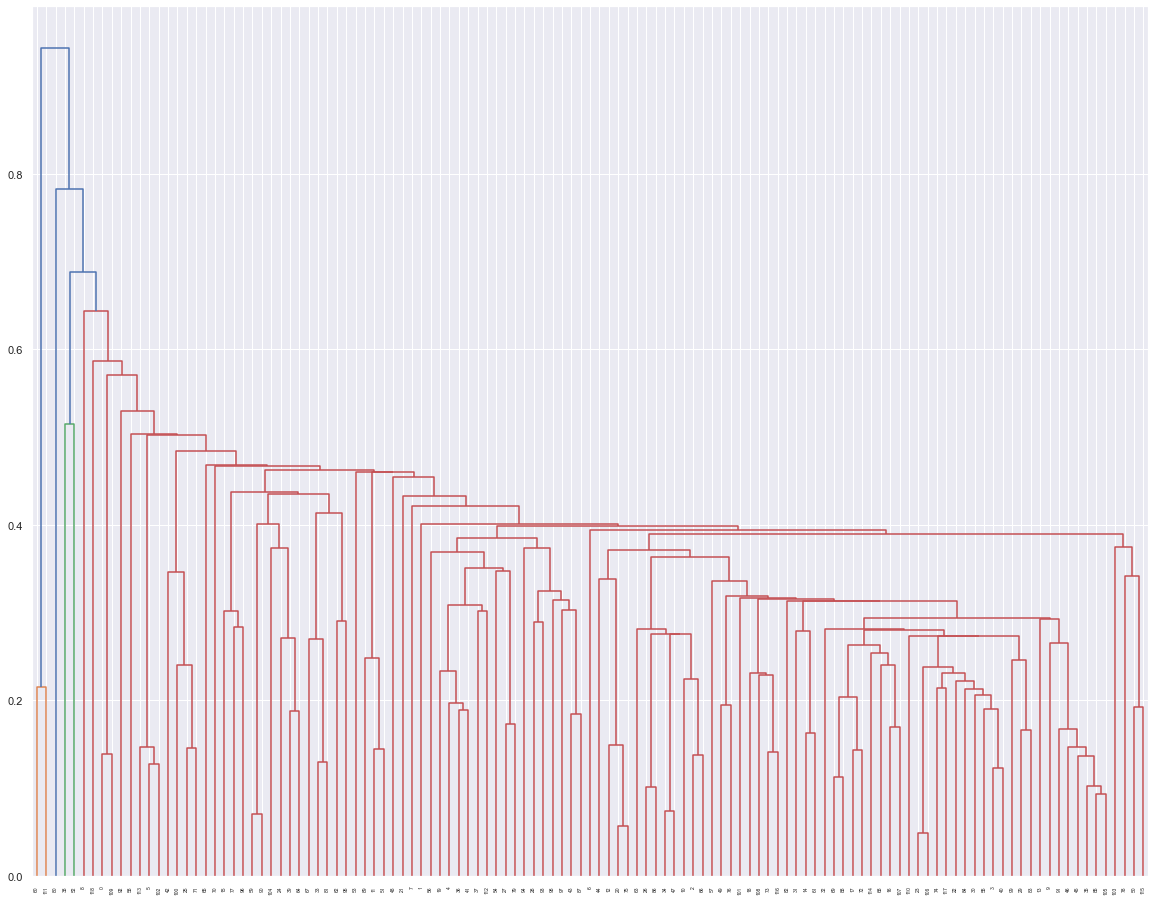

In [64]:
# Single linkage
plt.figure(figsize=[20,16])
mergings = linkage(pca_df_final_data, method='single',metric='euclidean')
dendrogram(mergings)
plt.show()

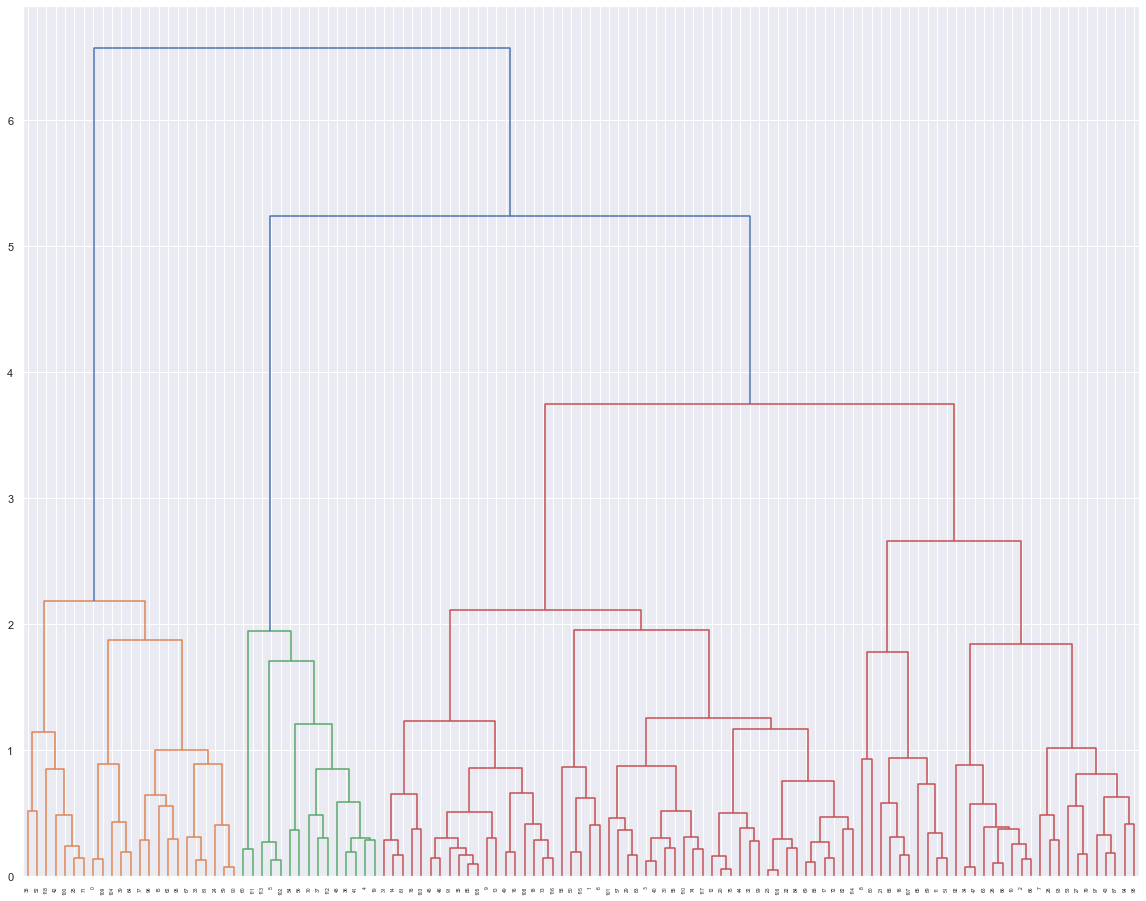

In [65]:
# Complete Linkage
plt.figure(figsize=[20,16])
mergings = linkage(pca_df_final_data, method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

In [66]:
pca_df_hc = pca_df_final.copy()
pca_df_hc = pca_df_hc.drop('Cluster_Id',axis=1)
pca_df_hc.head()

,country,PC_1,PC_2,PC_3
0,Afghanistan,-2.6374,1.4690,-0.5414
1,Algeria,-0.4576,-0.6733,0.9619
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501
3,Armenia,-0.3327,-1.2745,0.1766
4,Australia,3.1804,-0.2508,-0.1169


In [67]:
# Let cut the tree at height of approx 3 to get 4 clusters and see if it get any better cluster formation.

clusterCut = pd.Series(cut_tree(mergings, n_clusters = 4).reshape(-1,))
hc_df = pd.concat([pca_df_hc, clusterCut], axis=1)
hc_df.columns = ['country', 'PC_1', 'PC_2','PC_3','Cluster_Id']

In [68]:
hc_df.head()

,country,PC_1,PC_2,PC_3,Cluster_Id
0,Afghanistan,-2.6374,1.4690,-0.5414,0
1,Algeria,-0.4576,-0.6733,0.9619,1
2,Antigua and Barbuda,0.6498,-1.0244,-0.2501,2
3,Armenia,-0.3327,-1.2745,0.1766,1
4,Australia,3.1804,-0.2508,-0.1169,3


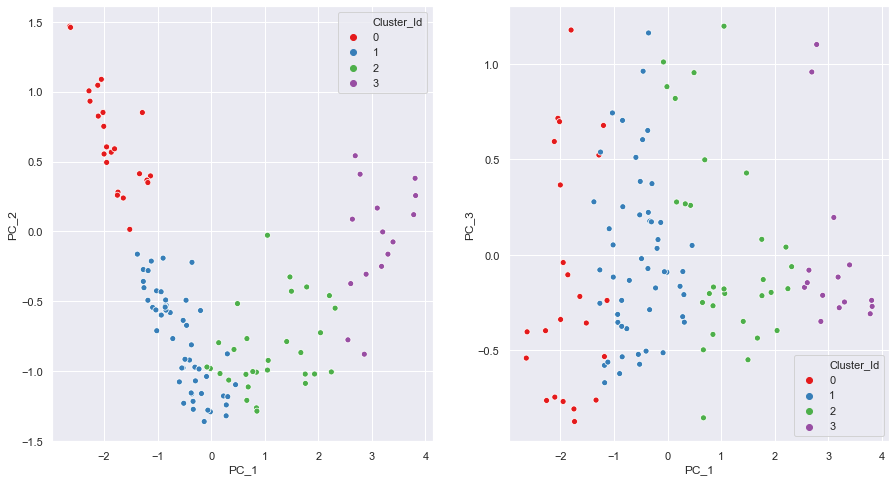

In [69]:
# Scatter plot on Principal components to visualize the spread of the data

fig, axes = plt.subplots(1,2, figsize=(15,8))

sns.scatterplot(x='PC_1',y='PC_2',hue='Cluster_Id',legend='full',palette="Set1",data=hc_df,ax=axes[0])
sns.scatterplot(x='PC_1',y='PC_3',hue='Cluster_Id',legend='full',palette="Set1",data=hc_df,ax=axes[1])

**Inference:** Cluster 4 seems to be not properly formed in Plot 1.

In [70]:
# Merging the df with PCA with original df

df_merge_hc = pd.merge(country_df,hc_df,on='country')
df_merge_col_hc = df_merge[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','Cluster_Id']]

In [71]:
df_merge_col_hc.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2000,55.3000,248.2970,41.9174,1610,9.4400,56.2000,5.8200,553,1
1,Algeria,27.3000,1712.6400,1400.4400,185.9820,12900,16.1000,76.5000,2.8900,4460,0
2,Antigua and Barbuda,10.3000,5551.0000,7185.8000,735.6600,19100,1.4400,76.8000,2.1300,12200,3
3,Armenia,18.1000,669.7600,1458.6600,141.6800,6700,7.7700,73.3000,1.6900,3220,0
4,Australia,4.8000,10276.2000,10847.1000,4530.8700,41400,1.1600,82.0000,1.9300,51900,2


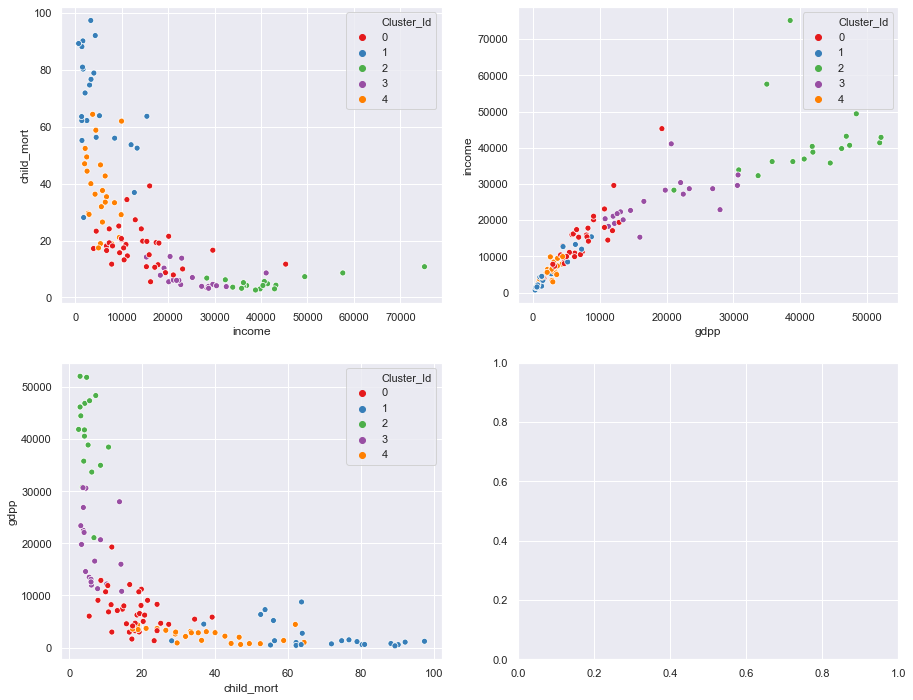

In [72]:
# Scatter plot on Original attributes to visualize the spread of the data

fig, axes = plt.subplots(2,2, figsize=(15,12))

sns.scatterplot(x = 'income', y = 'child_mort',hue='Cluster_Id',data = df_merge_col_hc,legend='full',palette="Set1",ax=axes[0][0])
sns.scatterplot(x = 'gdpp', y = 'income',hue='Cluster_Id', data = df_merge_col_hc,legend='full',palette="Set1",ax=axes[0][1])
sns.scatterplot(x = 'child_mort', y = 'gdpp',hue='Cluster_Id', data=df_merge_col_hc,legend='full',palette="Set1",ax=axes[1][0])

**Inferences:** We have analyzed both K-means and Hierarchial clustering and found clusters formed are not identical. The clusters formed in both the cases are not that great but its better in K-means as compared to Hierarchial. So, we will proceed with the clusters formed by K-means and based on the information provided by the final clusters we will deduce the final list of countries which are in need of aid.

## Final Analysis

We got Cluster 1 and Cluster 4 which are in need of aid.

In [73]:
df_clus1 = df_merge_col[df_merge_col['Cluster_Id'] ==1]

In [74]:
df_clus4 = df_merge_col[df_merge_col['Cluster_Id'] ==4]

In [75]:
df_append= df_clus1.append(df_clus4)

In [76]:
df_append.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2000,55.3000,248.2970,41.9174,1610,9.4400,56.2000,5.8200,553,1
15,Botswana,52.5000,2768.6000,3257.5500,527.0500,13300,8.9200,57.1000,2.8800,6350,1
24,Comoros,88.2000,126.8850,397.5730,34.6819,1410,3.8700,65.9000,4.7500,769,1
25,"Congo, Rep.",63.9000,2331.7400,1498.7800,67.4040,5190,20.7000,60.4000,4.9500,2740,1
33,Eritrea,55.2000,23.0878,112.3060,12.8212,1420,11.6000,61.7000,4.6100,482,1


In [77]:
df_clus1.shape

(23, 11)

In [78]:
df_clus4.shape

(25, 11)

In [79]:
df_append.shape

(48, 11)

In [80]:
df_append.describe()

,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000
mean,52.1958,909.2611,1048.5018,132.9976,5063.3333,8.5711,65.8479,3.7129,2290.3125,2.5625
std,22.1132,1048.6372,902.6188,138.0393,3530.3790,5.8186,4.9349,1.0533,1890.9810,1.5146
min,17.4000,1.0769,0.6511,12.8212,700.0000,0.5050,54.3000,2.3300,327.0000,1.0000
25%,33.4500,133.1355,290.7415,44.5167,2357.5000,3.8525,62.6500,2.7000,781.7500,1.0000
50%,52.4500,503.9400,694.1200,78.5355,4260.0000,7.7850,66.1500,3.5050,1430.0000,4.0000
75%,64.0250,1157.7825,1698.3000,167.0115,6507.5000,11.0750,69.6750,4.5700,3160.0000,4.0000
max,97.4000,5048.7500,3257.5500,650.8320,15400.0000,23.6000,75.8000,6.1500,8750.0000,4.0000


We have removed some countries during outlier treatment but we might have dropped some countries which might be in need of help.So, Let's iterate our final list based on the information from the clusters which were in need of aid.

In [81]:
# Based on final clusters information we are going to deduce the final list.
# We observed that mean child mortality is 53 for the selected clusters and hence 
# let's take all the countries with more than this child mortality .

df_final_list = country_df[country_df['child_mort']>53]
df_final_list.shape

(48, 10)

In [82]:
# Let's check the demographic of the resultant data again

df_final_list.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000,48.0000
mean,93.0208,848.1537,97.5164,754.1698,3695.0625,11.6195,59.5500,4.9121,1797.5000
std,32.4204,2266.2194,149.2196,1509.6237,5325.9968,15.4064,6.5526,1.1486,2852.8295
min,53.7000,1.0769,12.8212,0.6511,609.0000,0.8850,32.1000,2.4100,231.0000
25%,63.8500,101.6303,31.9700,188.8055,1390.0000,3.7925,56.7250,4.3450,551.5000
50%,89.7500,188.2900,48.7265,313.8570,1900.0000,8.2150,60.2500,5.0550,932.0000
75%,111.0000,417.9150,72.7850,571.8375,3785.0000,16.2250,63.8500,5.5975,1377.5000
max,208.0000,14671.8000,766.0800,10071.9000,33700.0000,104.0000,71.1000,7.4900,17100.0000


In [83]:
# We observed that mean income is 3695 for the selected clusters and hence 
# let's take all the countries with less than this income .

df_final_list1 = df_final_list[df_final_list['income']<=3695]
df_final_list1.shape

(35, 10)

In [84]:
# Let's check the demographic of the resultant data again

df_final_list1.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,35.0000,35.0000,35.0000,35.0000,35.0000,35.0000,35.0000,35.0000,35.0000
mean,98.7200,190.7614,56.9363,352.9760,1735.8000,8.4913,58.3771,5.2526,831.2000
std,32.8870,159.7151,56.7278,280.1672,769.1895,6.6906,6.9571,0.8977,606.5572
min,55.2000,20.6052,12.8212,90.5520,609.0000,0.8850,32.1000,3.3000,231.0000
25%,75.7000,80.3515,31.5122,170.5340,1215.0000,2.7900,56.2500,4.8100,470.5000
50%,90.5000,131.9850,41.9174,254.5600,1540.0000,6.3900,58.7000,5.2100,648.0000
75%,112.5000,224.5845,57.8575,400.2865,2135.0000,12.2000,62.0000,5.7650,1085.0000
max,208.0000,617.3200,328.3200,1190.5100,3370.0000,26.5000,71.1000,7.4900,3600.0000


In [85]:
# We observed that mean gdpp is 831 for the selected clusters and hence 
# let's take all the countries with less than this gdpp .

df_final_list2 = df_final_list1[df_final_list1['gdpp']<=831]
df_final_list2.shape

(23, 10)

**Final List of countries which are in need of the aid based on socio-economic factors are**

In [86]:
df_final_list2['country']

0      Afghanistan             
17     Benin                   
25     Burkina Faso            
26     Burundi                 
31     Central African Republic
36     Comoros                 
37     Congo, Dem. Rep.        
50     Eritrea                 
56     Gambia                  
63     Guinea                  
64     Guinea-Bissau           
66     Haiti                   
88     Liberia                 
93     Madagascar              
94     Malawi                  
97     Mali                    
106    Mozambique              
112    Niger                   
126    Rwanda                  
132    Sierra Leone            
147    Tanzania                
150    Togo                    
155    Uganda                  
Name: country, dtype: object

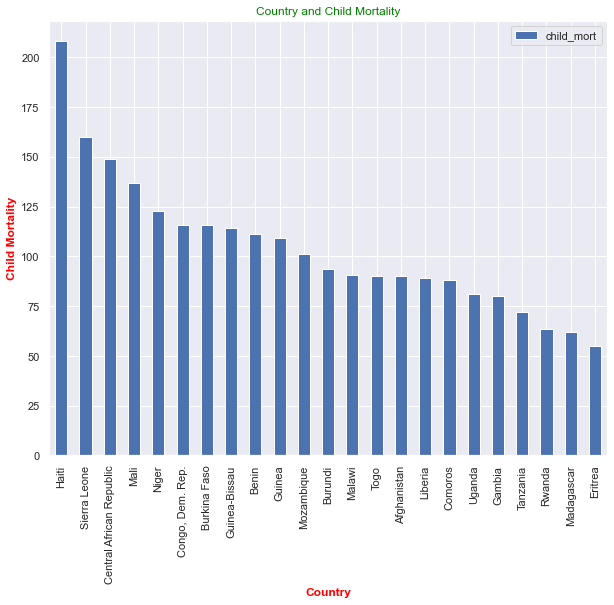

In [87]:
# BarPlot for Child Mortality of countries which are in need of aid

df_list_cm = pd.DataFrame(df_final_list2.groupby(['country'])['child_mort'].mean().sort_values(ascending = False))
df_list_cm.plot.bar()
plt.title('Country and Child Mortality', color = 'green')
plt.xlabel("Country",fontweight = 'bold', color='red')
plt.ylabel("Child Mortality", fontsize = 12, fontweight = 'bold', color='red')
plt.show()

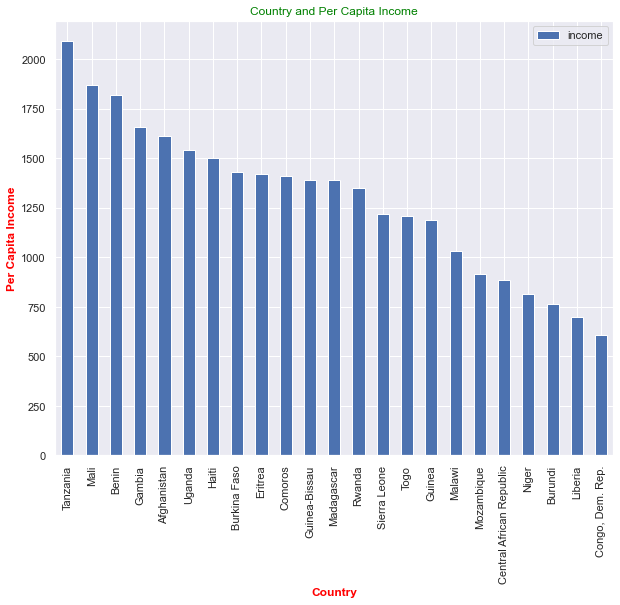

In [88]:
# BarPlot for Per Capita Income of countries which are in need of aid

df_list_in = pd.DataFrame(df_final_list2.groupby(['country'])['income'].mean().sort_values(ascending = False))
df_list_in.plot.bar()
plt.title('Country and Per Capita Income', color='green')
plt.xlabel("Country",fontweight = 'bold', color = 'red')
plt.ylabel("Per Capita Income", fontsize = 12, fontweight = 'bold', color='red')
plt.show()

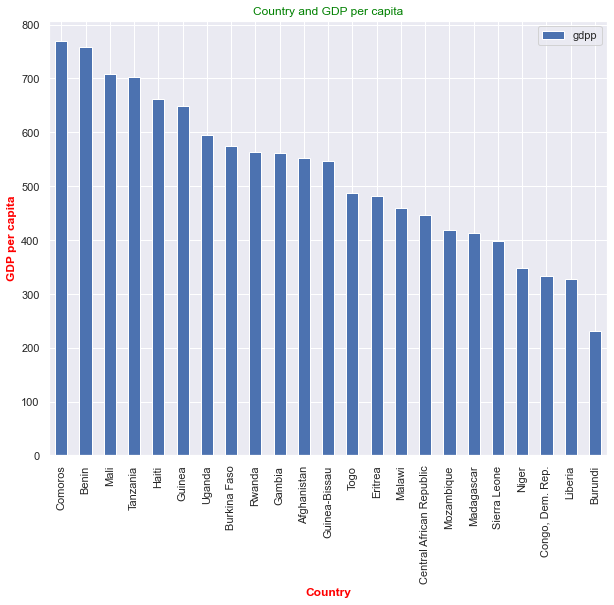

In [89]:
# BarPlot for Per Capita Income of countries which are in need of aid

df_list_gdp = pd.DataFrame(df_final_list2.groupby(['country'])['gdpp'].mean().sort_values(ascending = False))
df_list_gdp.plot.bar()
plt.title('Country and GDP per capita', color = 'green')
plt.xlabel("Country",fontweight = 'bold', color= 'red')
plt.ylabel("GDP per capita", fontsize = 12, fontweight = 'bold', color= 'red')
plt.show()

In [90]:
# Final countries list
df_final_list2.reset_index(drop=True).country

0     Afghanistan             
1     Benin                   
2     Burkina Faso            
3     Burundi                 
4     Central African Republic
5     Comoros                 
6     Congo, Dem. Rep.        
7     Eritrea                 
8     Gambia                  
9     Guinea                  
10    Guinea-Bissau           
11    Haiti                   
12    Liberia                 
13    Madagascar              
14    Malawi                  
15    Mali                    
16    Mozambique              
17    Niger                   
18    Rwanda                  
19    Sierra Leone            
20    Tanzania                
21    Togo                    
22    Uganda                  
Name: country, dtype: object

In [91]:
df_final_list2.shape

(23, 10)

## Conclusion

I used PCA firstly to reduce the variables involved and then did the clustering of countries based on those Principal components and then later i identified few factors like child mortality, income etc which plays an important role in deciding the development status of the country and built clusters of countries based on that. Based on those clusters i identified the below list of countries which are in dire need of aid. The list of countries are subject to change as it is based on the few factors like Number of components chosen, Number of Clusters chosen, Clustering method used etc.which i used to build the model.